In [1]:
# -*- coding: utf-8 -*- 

######################## IMPORT PACKAGES ########################
import pandas as pd
import numpy as np
import datetime 
import calendar 
import re 
import sys, logging, inspect 
from scipy.stats.mstats import gmean 
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper
import warnings 
from dateutil.relativedelta import relativedelta 

##################################################################


class Backtest: 
    """ Backtest a historical Crypto strategy. 
    Upon initialization, call method `Backtest.run` to run a backtest instance.  
    Initialize a backtest. Requires a historical selection table.  
    `selection` is a `pd.DataFrame` with columns: `cutoff`, `Symbol` and `Weight`.  
    If you have a weight column named differently rename it to `Weight`  or create a duplicate column with the correct name, e.g. df['Weight'] = df[`FFMC_Weight`]
    The passed data frame can contain additional columns. 
    """ 
    
    def __init__(self,
                 selection: pd.DataFrame,
                 exclusions = pd.DataFrame(columns = ['Symbol', 'exclusion_start_date']),
                 start_date=datetime.datetime(2010, 1, 1),
                 ref_currency="USD",
                 multiple_days_rebal = 1,
                 wave=1,
                 effective_dt = None,
                 wght_dt = None,
                 log_delistings = False):
        """
        Initialize a backtest. Requires a historical selection table.
        `selection` is a `pd.DataFrame` with columns: `cutoff`, `Symbol` and `Weight`.
        If you have a weight column named differently rename it to `Weight`  or create a duplicate column with the correct name, e.g. df['Weight'] = df[`FFMC_Weight`]
        The passed data frame can contain additional columns. 
        """  
        if not isinstance(selection, pd.DataFrame):
            raise TypeError("`selection` must be a pandas.DataFrame with columns") 
        
        selection = selection.copy(deep=False)
        # Some checks
        
        if not "cutoff" in selection.columns: 
            raise ValueError('`cutoff` column is missing in your selection table. ')
        
        if not "Weight" in selection.columns: 
            raise ValueError('`Weight` column is missing in your selection table. ' 'Please add it or rename it to `Weight`')
        
        if not "Symbol" in selection.columns:
            raise ValueError('`Symbol` column is missing in your selection table. ')
        
        if selection.cutoff.min() > start_date:
            raise ValueError('First `cutoff` is after the `start_date`. ' 'Please add a `cutoff` date prior to the `start_date` or ' 'change the `start_date`')
        
        self.selection = selection # Instance-level data
        self.exclusions = exclusions # Instance-level data
        self.start_date = start_date # Instance-level data
        self.ref_currency = ref_currency # Instance-level data
        self.log_delistings = log_delistings # Instance-level data
        self.wave = wave # Instance-level data 
        self.multiple_days_rebal = multiple_days_rebal # Instance-level data
        self.cutoff_dt = selection.cutoff.sort_values().drop_duplicates() # Instance-level data but infered from input
        
        try:
            self.cutoff_dt = pd.concat([pd.Series(self.cutoff_dt[self.cutoff_dt <self.start_date].iloc[-1]),
                                        self.cutoff_dt[ self.cutoff_dt > self.start_date]]).sort_values()
        except: 
            raise ValueError('There is something wrong in your dates, probably start date is before the first cutoff date.')
        
        if (wave == 1):
            if (not set(selection.cutoff.dt.month).intersection({2, 5, 8, 11}) == set(selection.cutoff.dt.month)):
                raise ValueError('You initialized your Backtest with wave = 1 but your cutoff dates are not from wave 1 '
                                 'Change the wave to wave 2, or '
                                 'use a selection table with the correct cutoffs')
            elif effective_dt is None:
                self.effective_dt = pd.Series(pd.to_datetime(self.first_wave_effective_dates()))
                
        if (wave == 2):
            if (not set(selection.cutoff.dt.month).intersection({1, 4, 7, 10}) == set(selection.cutoff.dt.month)):
                raise ValueError('You initialized your Backtest with wave = 2 but your cutoff dates are not from wave 2 '
                                 'Change the wave to wave 1, or ' 'use a selection table with the correct cutoffs') 
            elif effective_dt is None:
                self.effective_dt = pd.Series(pd.to_datetime(self.second_wave_effective_dates()))
                
        if wave not in [1, 2]:
            if effective_dt is None: 
                raise ValueError('Please input effective dates in the arguments of the function') 
            else: 
                self.effective_dt = effective_dt
            
        self.effective_dt = pd.concat([pd.Series(self.start_date), self.effective_dt[self.effective_dt> self.start_date]]).sort_values()
        self.effective_dt = pd.Series([self.effective_dt[self.effective_dt> c].iloc[0] for c in self.cutoff_dt])
        
        if wght_dt is None:
            self.wght_dt = self.effective_dt - datetime.timedelta(days =2)
        else:
            self.wght_dt = wght_dt
            
        self.wght_dt.iloc[0] = self.start_date 
        
        # Reformating all dates: 
        self.wght_dt =self.wght_dt.values
        self.effective_dt = self.effective_dt.values
        self.cutoff_dt = self.cutoff_dt.values 
        # Convert cutoff column to datetime index 
        selection.cutoff = pd.to_datetime(selection.cutoff) 
        # Infer rebalancing frequency
        self.frequency_rebal = selection.groupby(selection.cutoff.dt.year).cutoff.nunique().median()
        if self.frequency_rebal == 1:
            self.frequency_rebal = "Annual"
        elif self.frequency_rebal == 2:
            self.frequency_rebal = "Semi-Annual"
        elif self.frequency_rebal == 4:
            self.frequency_rebal = "Quarterly" 
            
        print("Backtest parameters:\n\n") 
        print("Start"+" "*(45 - len(f"Start{pd.to_datetime(self.start_date)}")) + f"{pd.to_datetime(self.start_date)}") 
        print("Frequency of rebalancing"+" "*(45 - len(f"Frequency of rebalancing{self.frequency_rebal}")) + f"{self.frequency_rebal}") 
        print("Currency"+" "*(45 - len(f"Currency{self.ref_currency}")) + f"{self.ref_currency}") 
        print("Wave"+" "*(45 - len(f"Wave{self.wave}")) + f"{self.wave}")  
        print("Rebalanced in"+" "*(45 - len(f"Rebalanced in{self.multiple_days_rebal} day(s)")) + f"{self.multiple_days_rebal} day(s)") 
        print("Log delistings"+" "*(45 - len(f"Log delistings{self.log_delistings}")) + f"{self.log_delistings}")
        
    def __str__(self):
        """
        Give the characteristics of the back test : wave, start date, currency (usd), rebal frequency...)
        """  
        return f"""
        Backtest:
    
        Start date: {self.start_date}
        Wave: {self.wave}
        Currency: {self.ref_currency}
        Rebal frequency: {self.frequency_rebal}
        N° of Fast Exists: {self.exclusions.shape[0]}
        N° of days for Weight Rebal: {self.multiple_days_rebal}
        Print de-listing logs: {self.log_delistings}
        """   
    
    def __repr__(self):
        return f"Backtest(start_date='{self.start_date}', " 
        f"wave={self.wave}, "  
        f"ref_currency={self.ref_currency}, " 
        f"multiple_days_rebal={self.multiple_days_rebal}, " 
        f"exclusions={self.exclusions})"   
    
    def performance_metrics(self, indices_ts, benchmark_ts):
        """
        Compute the main metrics of our indices related to the benchmark.
        """  

        annufactor = 255

        # Selection of yield column 
        returns_indices = indices_ts['Close'].pct_change().dropna()
        returns_benchmark = benchmark_ts['Close'].pct_change().dropna()

        # yield cumul
        cum_returns_indices = (1 + returns_indices).cumprod()
        cum_returns_benchmark = (1 + returns_benchmark).cumprod()

        # Realized return
        realized_return = (cum_returns_indices.iloc[-1] - 1) * 100
        print("Realized Return (%):", realized_return)

        # mean annualized return
        annualized_return = ((cum_returns_indices.iloc[-1] ** (annufactor / len(cum_returns_indices))) - 1) * 100
        print("Annualized Average Return (%):", annualized_return)

        # annualized vol
        annualized_volatility = returns_indices.std() * np.sqrt(annufactor) * 100
        print("Annualized Volatility (%):", annualized_volatility)

        # sharpe ratio
        sharpe_ratio = (annualized_return - 0) / annualized_volatility
        print("Sharpe Ratio:", sharpe_ratio)

        # Maximum Drawdown
        def max_drawdown(xs):
            i = np.argmax(np.maximum.accumulate(xs) - xs)
            j = np.argmax(xs[:i])
            return ((xs[j] - xs[i]) / xs[j]) * 100 if xs[j] != 0 else 0

        maximum_drawdown = max_drawdown(cum_returns_indices.values)
        print("Maximum Drawdown (%):", maximum_drawdown)

        # Value at Risk 5%
        value_at_risk = np.percentile(returns_indices, 5) * 100
        print("Value At Risk (%):", value_at_risk)

        # Tracking error
        tracking_error = np.sqrt(annufactor) * np.std(returns_indices - returns_benchmark) * 100
        print("Tracking Error (%):", tracking_error)

        # excess return
        excess_returns = returns_indices - returns_benchmark
        annualized_excess_return = ((1 + excess_returns.mean()) ** annufactor - 1) * 100
        print("Annualized Excess Return (%):", annualized_excess_return)

        # Information Ratio
        information_ratio = annualized_excess_return / tracking_error
        print("Information Ratio:", information_ratio)

        # Correlation with benchmark
        return_correlation = returns_indices.corr(returns_benchmark) * 100
        print("Return Correlation (%):", return_correlation)
        

    def generate_review_dates(self,
                              months,
                              weekday, #Monday, Tuesday, Wednesday, Thursday, Friday
                              weekday_position): #1 = first / -1 = last / 2 = 2nd / -2 = penultimate / etc.... 
    
        df_dates = pd.DataFrame(pd.bdate_range(start=self.start_date,
                                               end=datetime.datetime.now(),
                                               freq='D'), columns=['days']) 
    
        df_dates['days'] = pd.to_datetime(df_dates['days'], format='%Y-%m-%d')
        df_dates['weekday'] = df_dates['days'].dt.weekday
        df_dates['month'] = df_dates['days'].dt.month
        df_dates['year'] = df_dates['days'].dt.year
    
        if weekday_position > 0:
            df_dates.sort_values('days', ascending=True, inplace=True)
        elif weekday_position < 0:
            df_dates.sort_values('days', ascending=False, inplace=True)
        
        dict_weekday = {'Monday':0,
                        'Tuesday':1,
                        'Wednesday':2,
                        'Thursday':3,
                        'Friday':4}  
    
        df_dates = df_dates[df_dates['month'].isin(months) & (df_dates['weekday'] == dict_weekday[weekday])]
        df_dates['nb_of_friday'] = df_dates.groupby(['year','month']).cumcount() + 1
        output_dates = df_dates[df_dates['nb_of_friday'] == abs(weekday_position)]['days'].sort_values(ascending=True)
    
        return pd.to_datetime(output_dates).values 

    def first_wave_effective_dates(self):
        effective_dates = self.generate_review_dates([3, 6, 9, 12],
                                                 'Friday', 
                                                 3) 
        return effective_dates

    def second_wave_effective_dates(self, dates_to_remove=[datetime.datetime(2017, 4, 14),
                                                           datetime.datetime(2020, 4, 10)]): # static method
    
        effective_dates = self.generate_review_dates([1, 4, 7, 10],
                                                     'Friday',
                                                     2) 
        effective_dates = np.array([i - relativedelta(days=1) if i in dates_to_remove else i for i in effective_dates])
    
        return effective_dates  


    def run(self):
    
        print("Loading Prices...\n\n\n")
            
        # Normalize prices
        normalized_prices = self.selection.pivot(index='cutoff', columns='Symbol', values='Close')
        normalized_prices = (normalized_prices / normalized_prices.iloc[0] * 100)  # Normalisation à 100 pour le premier jour
        
        # Calc index
        index_final = normalized_prices.mean(axis=1)
        
    
        print("\n\n\nPrice loading finished successfully\n\n\n")
        
        # plot
        plt.figure(figsize=(10, 6))
        index_final.plot(label='Crypto Index', color='blue')
        plt.title('Performance de l\'indice des cryptomonnaies')
        plt.xlabel('Date')
        plt.ylabel('Niveau de l\'indice')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return index_final
    

        print("\nBacktest completed. \n")
        
    def quantitative_strategy_ma(self):
        print("Applying Quantitative Investment Strategy Moving Average...\n")

        # Selection price
        close_prices = self.selection.pivot(index='cutoff', columns='Symbol', values='Close')
        
        # MA 50 and 200 days
        short_window = 50
        long_window = 200
        
        short_rolling = close_prices.rolling(window=short_window).mean()
        long_rolling = close_prices.rolling(window=long_window).mean()

        # Genrate buy and sell signals
        buy_signals = short_rolling > long_rolling
        sell_signals = short_rolling < long_rolling
        
        # Initialize positions = 0 (hold) =1 (buy) = -1 (sell)
        positions = pd.DataFrame(0, index=close_prices.index, columns=close_prices.columns)
        positions[buy_signals] = 1
        positions[sell_signals] = -1

        # yield on positions took
        returns = positions.shift(1) * close_prices.pct_change()

        # yield cumulate
        cumulative_returns = (1 + returns).cumprod()

        # plot
        plt.figure(figsize=(10, 6))
        cumulative_returns.mean(axis=1).plot(label='Cumulative Returns', color='green')
        plt.title('Rendements Cumulés de la Stratégie Moving Average')
        plt.xlabel('Date')
        plt.ylabel('Rendement Cumulé')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("QiS Moving Average Strategy Applied Successfully.\n")
        
        return cumulative_returns.mean(axis=1)
    
    def quantitative_momentum_rebal(self):
        print("Applying Quantitative Investment Strategy based on Momemtum...\n")

        # price selection
        close_prices = self.selection.pivot(index='cutoff', columns='Symbol', values='Close')

        # daily return
        daily_returns = close_prices.pct_change()

        # window parameters
        short_window = 50
        long_window = 200

        # moving average
        short_rolling = close_prices.rolling(window=short_window).mean()
        long_rolling = close_prices.rolling(window=long_window).mean()

        # buy and sell signals
        buy_signals = short_rolling > long_rolling
        sell_signals = short_rolling < long_rolling

        # initialization
        positions = pd.DataFrame(0, index=close_prices.index, columns=close_prices.columns)

        # Rebal on position
        for i in range(1, len(close_prices)):
            if i % 20 == 0:  #  monthly rebal
                positions.iloc[i] = np.where(buy_signals.iloc[i], 1, np.where(sell_signals.iloc[i], -1, 0))
            else:  # keep old position
                positions.iloc[i] = positions.iloc[i - 1]

        # yield on position
        returns = positions.shift(1) * daily_returns

        # cum yield
        cumulative_returns = (1 + returns).cumprod()

        # plot
        plt.figure(figsize=(10, 6))
        cumulative_returns.mean(axis=1).plot(label='Cumulative Returns', color='orange')
        plt.title('Rendements Cumulés de la Stratégie Quantitative Momentum')
        plt.xlabel('Date')
        plt.ylabel('Rendement Cumulé')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("Complex Quantitative Investment Strategy Applied Successfully.\n")

        return cumulative_returns.mean(axis=1)
    
    def macd_strategy(self):
        print("Applying MACD Quantitative Investment Strategy...\n")

        # Price selection
        close_prices = self.selection.pivot(index='cutoff', columns='Symbol', values='Close')

        # daily yield
        daily_returns = close_prices.pct_change()

        # MACD parameters
        short_window = 12
        long_window = 26
        signal_window = 9

        # Moving average exponential
        short_ema = close_prices.ewm(span=short_window, adjust=False).mean()
        long_ema = close_prices.ewm(span=long_window, adjust=False).mean()

        # difference between short and long ema
        macd_line = short_ema - long_ema

        # signal line for macd
        signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

        # generate buy and sell signals
        buy_signals = macd_line > signal_line
        sell_signals = macd_line < signal_line

        # Initialize
        positions = pd.DataFrame(0, index=close_prices.index, columns=close_prices.columns)

        # Positions
        positions[buy_signals] = 1
        positions[sell_signals] = -1

        # yield on positions
        returns = positions.shift(1) * daily_returns

        # cum yield
        cumulative_returns = (1 + returns).cumprod()

        # plot
        plt.figure(figsize=(10, 6))
        cumulative_returns.mean(axis=1).plot(label='Cumulative Returns', color='purple')
        plt.title('Rendements Cumulés de la Stratégie MACD')
        plt.xlabel('Date')
        plt.ylabel('Rendement Cumulé')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("MACD Quantitative Investment Strategy Applied Successfully.\n")

        return cumulative_returns.mean(axis=1)
    
    def pairs_trading_strategy(self):
        print("Applying Pairs Trading Quantitative Investment Strategy...\n")

        # Price
        close_prices = self.selection.pivot(index='cutoff', columns='Symbol', values='Close')

        # Choose 2 asset with high correlation
        # here, BTC and ETH (we could change it..)
        asset1 = 'BTC'
        asset2 = 'ETH'

        prices_asset1 = close_prices[asset1]
        prices_asset2 = close_prices[asset2]

        # price ratio
        price_ratio = prices_asset1 / prices_asset2

        # mean and std of price ratio
        mean_ratio = price_ratio.mean()
        std_ratio = price_ratio.std()

        # threshold for position
        upper_threshold = mean_ratio + 1.5 * std_ratio
        lower_threshold = mean_ratio - 1.5 * std_ratio

        # Initialize
        positions = pd.DataFrame(0, index=close_prices.index, columns=[asset1, asset2])

        # Position
        for date in close_prices.index:
            ratio = prices_asset1.loc[date] / prices_asset2.loc[date]
            if ratio > upper_threshold:
                positions.loc[date, asset1] = -1  # Short asset1
                positions.loc[date, asset2] = 1   # Long asset2
            elif ratio < lower_threshold:
                positions.loc[date, asset1] = 1   # Long asset1
                positions.loc[date, asset2] = -1  # Short asset2

        # yield
        returns = positions.shift(1) * close_prices.pct_change()

        # cum yield
        cumulative_returns = (1 + returns).cumprod()

        # plot
        plt.figure(figsize=(10, 6))
        cumulative_returns.mean(axis=1).plot(label='Cumulative Returns', color='brown')
        plt.title('Rendements Cumulés de la Stratégie Pairs Trading')
        plt.xlabel('Date')
        plt.ylabel('Rendement Cumulé')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("Pairs Trading Quantitative Investment Strategy Applied Successfully.\n")

        return cumulative_returns.mean(axis=1)
    
    def momentum_crossover_strategy(self, short_window=20, long_window=50, volatility_window=50, volatility_threshold=0.2):
        """Implements a quantitative momentum crossover strategy with volatility filters."""
        
        print("Implementing Momentum Crossover Strategy with Volatility Filters...")

        # yield on window
        returns_short_window = self.selection['Close'].pct_change(short_window)
        returns_long_window = self.selection['Close'].pct_change(long_window)

        # vol on window
        volatility = returns_short_window.rolling(volatility_window).std()

        # Signal d'Achat : rendements courts > rendements longs et volatilité inférieure à un seuil
        buy_signal = (returns_short_window > returns_long_window) & (volatility < volatility_threshold)

        # Signal de Vente : rendements longs > rendements courts et volatilité inférieure à un seuil
        sell_signal = (returns_long_window > returns_short_window) & (volatility < volatility_threshold)

        positions = pd.DataFrame(index=self.selection.index)
        positions['Asset'] = self.selection['Symbol']

        positions['Position'] = np.where(buy_signal, 'Buy', np.where(sell_signal, 'Sell', 'Hold'))
        # 'Hold' if no signal

        # Plot buy and sell signal
        plt.figure(figsize=(10, 6))
        plt.plot(self.selection.index, self.selection['Close'], label='Price', color='black')

        plt.plot(self.selection.index[buy_signal], self.selection['Close'][buy_signal], '^', markersize=10, color='g', label='Buy Signal')
        plt.plot(self.selection.index[sell_signal], self.selection['Close'][sell_signal], 'v', markersize=10, color='r', label='Sell Signal')

        plt.title('Momentum Crossover Strategy with Volatility Filters')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        return positions

    def volume_weighted_strategy(self, window=30):
        # volumne average
        trading_volume = self.selection.pivot(index='cutoff', columns='Symbol', values='Volume')
        avg_volume = trading_volume.rolling(window=window).mean()
        
        # weight (based on inversed proportional volume)
        weights = 1 / avg_volume.iloc[-1]  # Supposons que la dernière période est représentative
        
        # Normalization to get 100%
        weights /= weights.sum()
        
        # Rebal
        rebalanced_weights = weights.to_dict()
        
        # get actual prices
        current_prices = self.selection[self.selection['cutoff'] == self.selection['cutoff'].max()].set_index('Symbol')['Close'].to_dict()
        
        positions = {}
        
        # Initialize portfolio value 
        total_portfolio_value = 100000  # Valeur hypothétique
        
        for symbol, weight in rebalanced_weights.items():
            # Rebalancing
            
            # Compute new position value
            position_value = weight * total_portfolio_value
            
            # Compute position value
            asset_quantity = position_value / current_prices[symbol]
            
            # rebal (based on the portfiolio)
            positions[symbol] = asset_quantity
        
        # displaying new positions)
        print("New Positions:", positions)
       
        return positions
    
    def plot_performance_intervals(self, benchmark_df):
        intervals = {
            '1Y': 365,
            '6M': 180,
            '3M': 90,
            '1M': 30,
        }

        plt.figure(figsize=(10, 6))

        for interval_name, interval_days in intervals.items():
            # compute date 
            start_dates = self.selection['cutoff'] - pd.Timedelta(days=interval_days)
            
            # yield cum list
            all_cum_returns_indice = []
            all_cum_returns_benchmark = []

            for start_date in start_dates.unique():
                # Filter dates
                date_filter = (self.selection['cutoff'] <= start_date) & (self.selection['cutoff'] >= start_date - pd.Timedelta(days=interval_days))
                filtered_indice = self.selection[date_filter]
                filtered_benchmark = benchmark_df[date_filter]

                if not filtered_indice.empty and not filtered_benchmark.empty:
                    # compute yield for bench and index
                    indice_returns = filtered_indice['Close'].pct_change().dropna()
                    benchmark_returns = filtered_benchmark['Close'].pct_change().dropna()

                    if not indice_returns.empty and not benchmark_returns.empty:
                        # yield cum
                        cum_returns_indice = (1 + indice_returns).cumprod().iloc[-1]
                        cum_returns_benchmark = (1 + benchmark_returns).cumprod().iloc[-1]

                        all_cum_returns_indice.append(cum_returns_indice)
                        all_cum_returns_benchmark.append(cum_returns_benchmark)

            # plot yield
            plt.plot(all_cum_returns_indice, label=f'Indice - {interval_name}')
            plt.plot(all_cum_returns_benchmark, label=f'Benchmark - {interval_name}')

        plt.title('Performance comparée sur différents intervalles')
        plt.xlabel('Intervalle')
        plt.ylabel('Cumulative Returns')
        plt.legend()
        plt.show()

            
    
    def getPrices(self): 
        """ 
        Load price table used in backtest 
        """ 
        return self.price  


    def getSelection(self): 
        """ 
        Load Selection Used in backtest 
        """ 
        return self.selection  

    def getExclusions(self): 
        """ 
        Load Exclusions used for fast exit in backtest 
        """ 
        return self.exclusions  


    def getMcapIndex(self): 
        """ 
        Load Historical Mcap of the index used in the backtest 
        """ 
        return self.mcapindex.reset_index()  


    def getTurnover(self): 
        """ 
        Get Turnover Table 
        """  
        stock_mcap_pivot = self.stock_mcap.pivot(index='Date', columns='Symbol', values='Mcap')
        stock_weigths = stock_mcap_pivot.div(stock_mcap_pivot.sum(axis=1), axis=0)
    
        after_review_weights = stock_weigths.loc[self.effective_dt].fillna(0)
        before_review_weights = stock_weigths.loc[(pd.to_datetime(self.effective_dt)-datetime.timedelta(days =1))].fillna(0).set_index(self.effective_dt)
    
        oneway_trunver = ((after_review_weights-before_review_weights).abs().sum(axis=1)/2).rename('One Way Turnover')
    
        inouts = (after_review_weights!=0).astype(int) - (before_review_weights!=0).astype(int)
        nbr_inouts = pd.concat([inouts[inouts>0].sum(axis=1), inouts[inouts<0].sum(axis=1)],
                           axis=1, keys=['Nbr Ins', 'Nbr Outs'])
    
        nbr_stocks = pd.concat([(before_review_weights!=0).sum(axis=1), (after_review_weights!=0).sum(axis=1)],
                           axis=1, keys =['Nbr Stocks Before Review', 'Nbr Stocks After Review'])
    
        summary_turn = pd.concat([oneway_trunver, nbr_stocks, nbr_inouts], axis=1)  
    
        return summary_turn
 

    def getWeightRepartition(self, column="Industry Name"):
        """
        Returns a pd.DataFrame that contains the weight split accross a given column at the last cutoff.
        `column` is a `str` which refers to the column used to group by the weights.
        """  
        if not column in self.selection.columns:
            raise ValueError(f'{column} is not among the columns of your selection table.' 
                             'Please add it')
        weightsplit = self.selection.loc[self.selection.cutoff == self.selection.cutoff.max()].\
        groupby(column)['Weight'].sum().sort_values(ascending=False).reset_index()
    
        return weightsplit

    def setStartDate(self, start_date):
        """ 
        Method to modify start date of the backtest 
        """
        self.start_date = start_date  
        print("Start Date modified. New backtest parameters:\n\n") 
        print("Start"+" "*(45 - len(f"Start{pd.to_datetime(self.start_date)}")) + f"{pd.to_datetime(self.start_date)}") 
        print("Frequency of rebalancing"+" "*(45 - len(f"Frequency of rebalancing{self.frequency_rebal}")) + f"{self.frequency_rebal}") 
        print("Currency"+" "*(45 - len(f"Currency{self.ref_currency}")) + f"{self.ref_currency}") 
        print("Wave"+" "*(45 - len(f"Wave{self.wave}")) + f"{self.wave}")  
        print("Rebalanced in"+" "*(45 - len(f"Rebalanced in{self.multiple_days_rebal} day(s)")) + f"{self.multiple_days_rebal} day(s)")
        print("Log delistings"+" "*(45 - len(f"Log delistings{self.log_delistings}")) + f"{self.log_delistings}")  
    
    def setCurrency(self, ref_currency):
        """ 
        Method to modify currency of the backtest 
        """ 
        self.ref_currency = ref_currency 
        print("Currency modified. New backtest parameters:\n\n") 
        print("Start"+" "*(45 - len(f"Start{pd.to_datetime(self.start_date)}")) + f"{pd.to_datetime(self.start_date)}") 
        print("Frequency of rebalancing"+" "*(45 - len(f"Frequency of rebalancing{self.frequency_rebal}")) + f"{self.frequency_rebal}") 
        print("Currency"+" "*(45 - len(f"Currency{self.ref_currency}")) + f"{self.ref_currency}") 
        print("Wave"+" "*(45 - len(f"Wave{self.wave}")) + f"{self.wave}")  
        print("Rebalanced in"+" "*(45 - len(f"Rebalanced in{self.multiple_days_rebal} day(s)")) + f"{self.multiple_days_rebal} day(s)") 
        print("Log delistings"+" "*(45 - len(f"Log delistings{self.log_delistings}")) + f"{self.log_delistings}")  
        
    
    def setExclusions(self, exclusions):
        """ 
        Method to modify fast exit table used in the backtest 
        """ 
        self.exclusions = exclusions  
        print("Fast exit table modified:\n\n") 
        print(self.exclusions)  
        
    def setMultipleDaysRebal(self, multiple_days_rebal):
        """ 
        Method to modify number of days of rebalancing in the backtest 
        """ 
        self.multiple_days_rebal = multiple_days_rebal  
        print("Number of days for the rebalancing modified. New backtest parameters:\n\n") 
        print("Start"+" "*(45 - len(f"Start{pd.to_datetime(self.start_date)}")) + f"{pd.to_datetime(self.start_date)}") 
        print("Frequency of rebalancing"+" "*(45 - len(f"Frequency of rebalancing{self.frequency_rebal}")) + f"{self.frequency_rebal}")
        print("Currency"+" "*(45 - len(f"Currency{self.ref_currency}")) + f"{self.ref_currency}") 
        print("Wave"+" "*(45 - len(f"Wave{self.wave}")) + f"{self.wave}")  
        print("Rebalanced in"+" "*(45 - len(f"Rebalanced in{self.multiple_days_rebal} day(s)")) + f"{self.multiple_days_rebal} day(s)") 
        print("Log delistings"+" "*(45 - len(f"Log delistings{self.log_delistings}")) + f"{self.log_delistings}")  
        
    def setWave(self, wave):
        """ 
        Method to modify the cutoff wave in the backtest 
        """  
        if (wave == 1) & (not set(self.selection.cutoff.dt.month).intersection({2, 5, 8, 11}) == set(self.selection.cutoff.dt.month)):
            raise ValueError('You initialized your Backtest with wave = 1 but your cutoff dates are not from wave 1 '
                             'Change the wave to wave 2, or ' 
                             'use a selection table with the correct cutoffs') 
        if (wave == 2) & (not set(self.selection.cutoff.dt.month).intersection({1, 4, 7, 10}) == set(self.selection.cutoff.dt.month)): 
            raise ValueError('You initialized your Backtest with wave = 2 but your cutoff dates are not from wave 2 ' 
                             'Change the wave to wave 1, or ' 
                             'use a selection table with the correct cutoffs') 
        
        self.wave = wave  
        print("Number of days for the rebalancing modified. New backtest parameters:\n\n") 
        print("Start"+" "*(45 - len(f"Start{pd.to_datetime(self.start_date)}")) + f"{pd.to_datetime(self.start_date)}") 
        print("Frequency of rebalancing"+" "*(45 - len(f"Frequency of rebalancing{self.frequency_rebal}")) + f"{self.frequency_rebal}") 
        print("Currency"+" "*(45 - len(f"Currency{self.ref_currency}")) + f"{self.ref_currency}") 
        print("Wave"+" "*(45 - len(f"Wave{self.wave}")) + f"{self.wave}")  
        print("Rebalanced in"+" "*(45 - len(f"Rebalanced in{self.multiple_days_rebal} day(s)")) + f"{self.multiple_days_rebal} day(s)") 
        print("Log delistings"+" "*(45 - len(f"Log delistings{self.log_delistings}")) + f"{self.log_delistings}")  
        
    def setLogDelistings(self, log_delistings): 
        """ 
        Method to turn on/off the potential delisting alerts in the backtest 
        """ 
        self.log_delistings = log_delistings  
        print("Number of days for the rebalancing modified. New backtest parameters:\n\n") 
        print("Start"+" "*(45 - len(f"Start{pd.to_datetime(self.start_date)}")) + f"{pd.to_datetime(self.start_date)}") 
        print("Frequency of rebalancing"+" "*(45 - len(f"Frequency of rebalancing{self.frequency_rebal}")) + f"{self.frequency_rebal}") 
        print("Currency"+" "*(45 - len(f"Currency{self.ref_currency}")) + f"{self.ref_currency}") 
        print("Wave"+" "*(45 - len(f"Wave{self.wave}")) + f"{self.wave}")  
        print("Rebalanced in"+" "*(45 - len(f"Rebalanced in{self.multiple_days_rebal} day(s)")) + f"{self.multiple_days_rebal} day(s)") 
        print("Log delistings"+" "*(45 - len(f"Log delistings{self.log_delistings}")) + f"{self.log_delistings}")
    

In [2]:
from cryptocmd import CmcScraper
import pandas as pd

# Crypto DF
########################## SYMBOL SELECTION AND DATES ################################
crypto_df = pd.DataFrame({"CRYPTO": ["BTC", "ETH", "XRP"]})  # choose here the symbol

date_from = "01-01-2017" # first date
date_to = "01-12-2023" # last date

#####################################################################################

# creatting the dataframe
combined_data = pd.DataFrame()

# get list of symbol from initial DF
crypto_list = crypto_df["CRYPTO"].tolist()

# use CMC scraper to scrap CMC easily without any API restriction :)
for currency in crypto_list:
    if date_from and date_to:
        scraper = CmcScraper(currency, date_from, date_to)
    else:
        scraper = CmcScraper(currency)

    headers, data = scraper.get_data()
    json_data = scraper.get_data("json")
    df = scraper.get_dataframe()
    
    # Add a symbol column in the DF
    df["Symbol"] = currency
    
    # Concatenate
    combined_data = pd.concat([combined_data, df], ignore_index=True)

In [3]:
# Groupe by and count the nb of lines by size
counts = combined_data.groupby('Date').size()

# filter data (inferior to 3)
dates_to_remove = counts[counts != 3].index

# Delete them
df = combined_data[~combined_data['Date'].isin(dates_to_remove)]

# Verify is is null or 0
dates_with_zero_or_null = df[(df['Market Cap'].isnull()) | (df['Market Cap'] == 0)]['Date'].unique()

# delete them
df = df[~df['Date'].isin(dates_with_zero_or_null)]

# GroupBy to get the market cap
df['Total Market Cap'] = df.groupby('Date')['Market Cap'].transform('sum')

# ... and weight
df['Weight'] = df['Market Cap'] / df['Total Market Cap']

df.rename(columns={'Date': 'cutoff'}, inplace=True)

# get right datetime type
df['cutoff'] = pd.to_datetime(df['cutoff'])

# filter those month to first cutoff (=useful to rebalance...)
months_to_keep = [2, 5, 8, 11]
df = df[df['cutoff'].dt.month.isin(months_to_keep)]

df = df.assign(Dividends=0)
df = df.assign(Country='US')



In [4]:
selection = df


In [5]:
selection

,cutoff,Open,High,Low,Close,Volume,Market Cap,Time Open,Time High,Time Low,Time Close,Symbol,Total Market Cap,Weight,Dividends,Country
1,2023-11-30,37861.118883,38141.753547,37531.141629,37712.747772,1.811598e+10,7.375609e+11,2023-11-30T00:00:00.000Z,2023-11-30T04:16:00.000Z,2023-11-30T15:50:00.000Z,2023-11-30T23:59:59.999Z,BTC,1.017037e+12,0.725206,0,US
2,2023-11-29,37826.105522,38366.112997,37612.631623,37858.494055,2.072855e+10,7.403799e+11,2023-11-29T00:00:00.000Z,2023-11-29T08:58:00.000Z,2023-11-29T15:14:00.000Z,2023-11-29T23:59:59.999Z,BTC,1.017297e+12,0.727791,0,US
3,2023-11-28,37247.991175,38368.479955,36891.089362,37831.086868,2.169614e+10,7.398131e+11,2023-11-28T00:00:00.000Z,2023-11-28T19:43:00.000Z,2023-11-28T05:39:00.000Z,2023-11-28T23:59:59.999Z,BTC,1.019138e+12,0.725920,0,US
4,2023-11-27,37454.191955,37559.354550,36750.127105,37254.168854,1.900293e+10,7.284955e+11,2023-11-27T00:00:00.000Z,2023-11-27T01:08:00.000Z,2023-11-27T16:02:00.000Z,2023-11-27T23:59:59.999Z,BTC,1.004796e+12,0.725018,0,US
5,2023-11-26,37796.828864,37820.301342,37162.749154,37479.122294,1.374480e+10,7.328642e+11,2023-11-26T00:00:00.000Z,2023-11-26T08:35:00.000Z,2023-11-26T17:02:00.000Z,2023-11-26T23:59:59.999Z,BTC,1.014160e+12,0.722632,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7542,2017-02-05,0.006494,0.006563,0.006403,0.006442,3.670010e+05,2.374392e+08,2017-02-05T00:00:00.000Z,2017-02-05T11:29:02.000Z,2017-02-05T18:24:02.000Z,2017-02-05T23:59:59.999Z,XRP,1.783153e+10,0.013316,0,US
7543,2017-02-04,0.006487,0.006528,0.006429,0.006492,3.141870e+05,2.392776e+08,2017-02-04T00:00:00.000Z,2017-02-04T20:19:02.000Z,2017-02-04T03:34:02.000Z,2017-02-04T23:59:59.999Z,XRP,1.808932e+10,0.013228,0,US
7544,2017-02-03,0.006466,0.006510,0.006401,0.006474,5.482630e+05,2.386061e+08,2017-02-03T00:00:00.000Z,2017-02-03T02:14:02.000Z,2017-02-03T06:59:01.000Z,2017-02-03T23:59:59.999Z,XRP,1.784848e+10,0.013368,0,US
7545,2017-02-02,0.006540,0.006630,0.006381,0.006469,6.708880e+05,2.384296e+08,2017-02-02T00:00:00.000Z,2017-02-02T01:14:17.000Z,2017-02-02T17:34:02.000Z,2017-02-02T23:59:59.999Z,XRP,1.752778e+10,0.013603,0,US


In [6]:
test = Backtest(selection, start_date=datetime.datetime(2019, 1, 1), )

Backtest parameters:


Start                     2019-01-01 00:00:00
Frequency of rebalancing                120.0
Currency                                  USD
Wave                                        1
Rebalanced in                        1 day(s)
Log delistings                          False


Loading Prices...






Price loading finished successfully





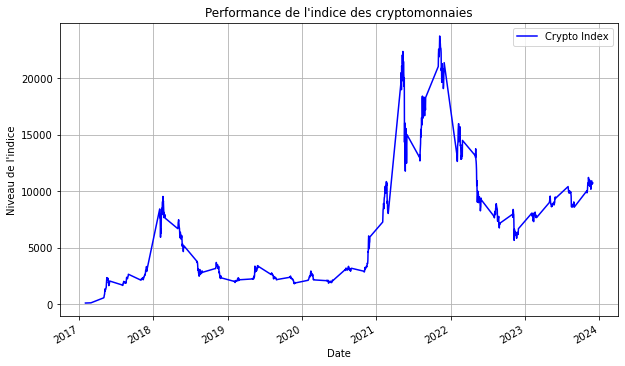

cutoff
2017-02-01      100.000000
2017-02-02      100.686177
2017-02-03      102.231314
2017-02-04      103.752788
2017-02-05      102.724085
                  ...     
2023-11-26    10815.682681
2023-11-27    10632.133181
2023-11-28    10756.713734
2023-11-29    10686.834290
2023-11-30    10736.905665
Length: 841, dtype: float64

In [7]:
test.run()

In [8]:
#### Same procedure as above, while here we try to concatenate more cryptocurrencies

crypto_df = pd.DataFrame({"CRYPTO": ["BTC", "ETH", "XRP", "ADA", "FTM", "BNB", "SOL"]})  # Exemple de DataFrame avec des symboles

date_from = "01-01-2017"
date_to = "01-12-2023"

combined_data = pd.DataFrame()

crypto_list = crypto_df["CRYPTO"].tolist()

for currency in crypto_list:
    if date_from and date_to:
        scraper = CmcScraper(currency, date_from, date_to)
    else:
        scraper = CmcScraper(currency)

    headers, data = scraper.get_data()
    json_data = scraper.get_data("json")
    df = scraper.get_dataframe()
    
    df["Symbol"] = currency
    
    bench = pd.concat([combined_data, df], ignore_index=True)
    
    

In [9]:
##### Same procedure as above

counts = bench.groupby('Date').size()

crypto_uni = bench['Symbol'].nunique()

dates_to_remove = counts[counts != crypto_uni].index

df = bench[~bench['Date'].isin(dates_to_remove)]

dates_with_zero_or_null = bench[(bench['Market Cap'].isnull()) | (bench['Market Cap'] == 0)]['Date'].unique()

bench = bench[~bench['Date'].isin(dates_with_zero_or_null)]

bench['Total Market Cap'] = bench.groupby('Date')['Market Cap'].transform('sum')

bench['Weight'] = bench['Market Cap'] / bench['Total Market Cap']

bench.rename(columns={'Date': 'cutoff'}, inplace=True)

bench['cutoff'] = pd.to_datetime(bench['cutoff'])

months_to_keep = [2, 5, 8, 11]
bench = bench[bench['cutoff'].dt.month.isin(months_to_keep)]

bench = bench.assign(Dividends=0)
bench = bench.assign(Country='US')

In [10]:
test.performance_metrics(selection, bench)

Realized Return (%): -99.99998265962968
Annualized Average Return (%): -79.27952835430376
Annualized Volatility (%): 130.6888908385815
Sharpe Ratio: -0.6066279072811531
Maximum Drawdown (%): 99.99999180716365
Value At Risk (%): -9.267737204716179
Tracking Error (%): 212.55477940195263
Annualized Excess Return (%): -39.24140183813145
Information Ratio: -0.18461782863006732
Return Correlation (%): 47.791812645573806


In [15]:
constituents_data = pd.read_csv("Constituents-CoinDesk-Market-Index.csv")

constituents_data['Symbol'] = constituents_data['Symbol'].str.upper()


# Fusion des deux DataFrames en utilisant la colonne "Symbol" comme clé de correspondance
selection = pd.merge(selection, constituents_data[['Symbol', 'DACS Industry Group']], on='Symbol', how='left')

# Renommer la colonne 'DACS Industry Group' en 'Industry Name'
selection.rename(columns={'DACS Industry Group': 'Industry Name'}, inplace=True)

In [16]:
selection

,cutoff,Open,High,Low,Close,Volume,Market Cap,Time Open,Time High,Time Low,Time Close,Symbol,Total Market Cap,Weight,Dividends,Country,Industry Name
0,2023-11-30,37861.118883,38141.753547,37531.141629,37712.747772,1.811598e+10,7.375609e+11,2023-11-30T00:00:00.000Z,2023-11-30T04:16:00.000Z,2023-11-30T15:50:00.000Z,2023-11-30T23:59:59.999Z,BTC,1.017037e+12,0.725206,0,US,Transparent
1,2023-11-29,37826.105522,38366.112997,37612.631623,37858.494055,2.072855e+10,7.403799e+11,2023-11-29T00:00:00.000Z,2023-11-29T08:58:00.000Z,2023-11-29T15:14:00.000Z,2023-11-29T23:59:59.999Z,BTC,1.017297e+12,0.727791,0,US,Transparent
2,2023-11-28,37247.991175,38368.479955,36891.089362,37831.086868,2.169614e+10,7.398131e+11,2023-11-28T00:00:00.000Z,2023-11-28T19:43:00.000Z,2023-11-28T05:39:00.000Z,2023-11-28T23:59:59.999Z,BTC,1.019138e+12,0.725920,0,US,Transparent
3,2023-11-27,37454.191955,37559.354550,36750.127105,37254.168854,1.900293e+10,7.284955e+11,2023-11-27T00:00:00.000Z,2023-11-27T01:08:00.000Z,2023-11-27T16:02:00.000Z,2023-11-27T23:59:59.999Z,BTC,1.004796e+12,0.725018,0,US,Transparent
4,2023-11-26,37796.828864,37820.301342,37162.749154,37479.122294,1.374480e+10,7.328642e+11,2023-11-26T00:00:00.000Z,2023-11-26T08:35:00.000Z,2023-11-26T17:02:00.000Z,2023-11-26T23:59:59.999Z,BTC,1.014160e+12,0.722632,0,US,Transparent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,2017-02-05,0.006494,0.006563,0.006403,0.006442,3.670010e+05,2.374392e+08,2017-02-05T00:00:00.000Z,2017-02-05T11:29:02.000Z,2017-02-05T18:24:02.000Z,2017-02-05T23:59:59.999Z,XRP,1.783153e+10,0.013316,0,US,BaaS
2519,2017-02-04,0.006487,0.006528,0.006429,0.006492,3.141870e+05,2.392776e+08,2017-02-04T00:00:00.000Z,2017-02-04T20:19:02.000Z,2017-02-04T03:34:02.000Z,2017-02-04T23:59:59.999Z,XRP,1.808932e+10,0.013228,0,US,BaaS
2520,2017-02-03,0.006466,0.006510,0.006401,0.006474,5.482630e+05,2.386061e+08,2017-02-03T00:00:00.000Z,2017-02-03T02:14:02.000Z,2017-02-03T06:59:01.000Z,2017-02-03T23:59:59.999Z,XRP,1.784848e+10,0.013368,0,US,BaaS
2521,2017-02-02,0.006540,0.006630,0.006381,0.006469,6.708880e+05,2.384296e+08,2017-02-02T00:00:00.000Z,2017-02-02T01:14:17.000Z,2017-02-02T17:34:02.000Z,2017-02-02T23:59:59.999Z,XRP,1.752778e+10,0.013603,0,US,BaaS


In [17]:
test = Backtest(selection, start_date=datetime.datetime(2019, 1, 1), )

Backtest parameters:


Start                     2019-01-01 00:00:00
Frequency of rebalancing                120.0
Currency                                  USD
Wave                                        1
Rebalanced in                        1 day(s)
Log delistings                          False


In [18]:
test.getWeightRepartition()

,Industry Name,Weight
0,Transparent,0.725206
1,Layer 1,0.242666
2,BaaS,0.032128


In [19]:
# Supposons que crypto_df est votre DataFrame contenant les symboles de cryptomonnaies
crypto_df = pd.DataFrame({"CRYPTO": ["BTC", "ETH", "XRP", "BNB", "AAVE", "FTM", "SOL"]})  # Exemple de DataFrame avec des symboles

date_from = "01-01-2017"
date_to = "01-01-2023"

# Créer un DataFrame vide pour stocker toutes les données
combined_data = pd.DataFrame()

# Récupérer la liste des symboles de cryptomonnaies à partir du DataFrame
crypto_list = crypto_df["CRYPTO"].tolist()

for currency in crypto_list:
    if date_from and date_to:
        scraper = CmcScraper(currency, date_from, date_to)
    else:
        scraper = CmcScraper(currency)

    headers, data = scraper.get_data()
    json_data = scraper.get_data("json")
    df = scraper.get_dataframe()
    
    # Ajouter une colonne "Symbol" avec le nom de la cryptomonnaie
    df["Symbol"] = currency
    
    # Concaténer les données dans un DataFrame combiné
    mnemo = pd.concat([combined_data, df], ignore_index=True)

In [20]:
# Grouper par date et compter le nombre de lignes par date
counts = mnemo.groupby('Date').size()

crypto_uni = mnemo['Symbol'].nunique()

# Filtrer les dates qui n'ont pas les 5 lignes pour chaque devise
dates_to_remove = counts[counts != crypto_uni].index

# Supprimer les lignes correspondant aux dates à enlever
mnemo = mnemo[~mnemo['Date'].isin(dates_to_remove)]

# Vérifier s'il y a au moins une ligne avec Market Cap nul ou égal à zéro pour chaque date
dates_with_zero_or_null = mnemo[(mnemo['Market Cap'].isnull()) | (mnemo['Market Cap'] == 0)]['Date'].unique()

# Supprimer les dates avec des valeurs nulles ou égales à zéro dans la colonne 'Market Cap'
mnemo = mnemo[~mnemo['Date'].isin(dates_with_zero_or_null)]

# Calculer la somme des Market Cap pour chaque jour
mnemo['Total Market Cap'] = mnemo.groupby('Date')['Market Cap'].transform('sum')

# Calculer le poids de chaque devise par rapport à la somme des Market Cap
mnemo['Weight'] = mnemo['Market Cap'] / mnemo['Total Market Cap']

mnemo.rename(columns={'Date': 'calculation_date'}, inplace=True)

# Convertir la colonne 'cutoff' en type datetime si elle n'est pas déjà au bon format
mnemo['calculation_date'] = pd.to_datetime(mnemo['calculation_date'])

# Filtrer pour ne garder que les mois 2, 5, 8 et 11
months_to_keep = [2, 5, 8, 11]
mnemo = mnemo[mnemo['calculation_date'].dt.month.isin(months_to_keep)]

mnemo = bench.assign(Dividends=0)
mnemo = bench.assign(Country='US')
mnemo = bench.assign(index_mnemonic='CMC')
mnemo.rename(columns={'cutoff': 'calculation_date'}, inplace=True)
mnemo.rename(columns={'Close': 'close_unrounded'}, inplace=True)



Applying Quantitative Investment Strategy Moving Average...



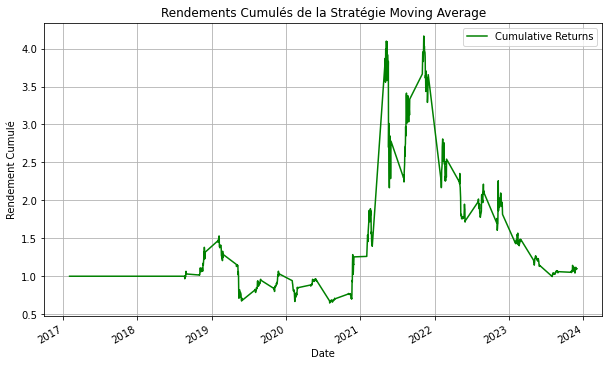

QiS Moving Average Strategy Applied Successfully.



cutoff
2017-02-01         NaN
2017-02-02    1.000000
2017-02-03    1.000000
2017-02-04    1.000000
2017-02-05    1.000000
                ...   
2023-11-26    1.106321
2023-11-27    1.088099
2023-11-28    1.100916
2023-11-29    1.093694
2023-11-30    1.099368
Length: 841, dtype: float64

In [21]:
test.quantitative_strategy_ma()

Applying Quantitative Investment Strategy based on Momemtum...



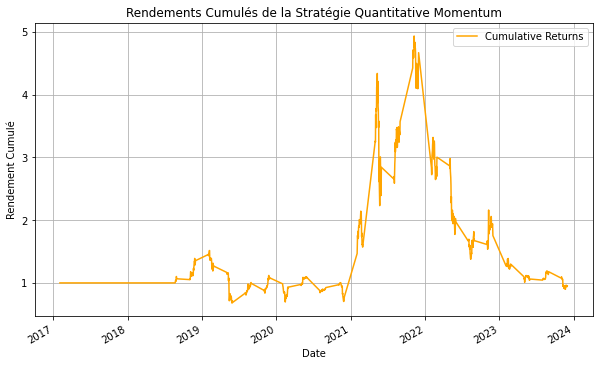

Complex Quantitative Investment Strategy Applied Successfully.



cutoff
2017-02-01         NaN
2017-02-02    1.000000
2017-02-03    1.000000
2017-02-04    1.000000
2017-02-05    1.000000
                ...   
2023-11-26    0.954303
2023-11-27    0.938689
2023-11-28    0.949321
2023-11-29    0.941513
2023-11-30    0.950029
Length: 841, dtype: float64

In [22]:
test.quantitative_momentum_rebal()

Applying MACD Quantitative Investment Strategy...



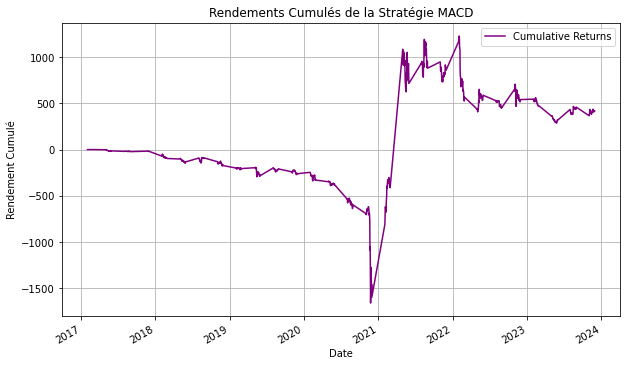

MACD Quantitative Investment Strategy Applied Successfully.



cutoff
2017-02-01           NaN
2017-02-02      1.000000
2017-02-03      1.014748
2017-02-04      1.027916
2017-02-05      1.022862
                 ...    
2023-11-26    411.432875
2023-11-27    419.902206
2023-11-28    414.840569
2023-11-29    416.195749
2023-11-30    418.363605
Length: 841, dtype: float64

In [23]:
test.macd_strategy()

Applying Pairs Trading Quantitative Investment Strategy...



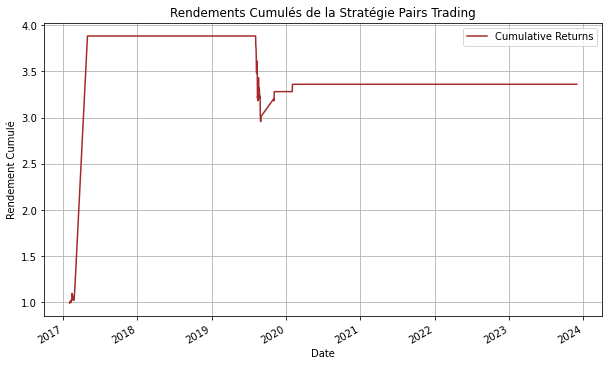

Pairs Trading Quantitative Investment Strategy Applied Successfully.



cutoff
2017-02-01         NaN
2017-02-02    0.992646
2017-02-03    0.997558
2017-02-04    1.006369
2017-02-05    1.009686
                ...   
2023-11-26    3.360780
2023-11-27    3.360780
2023-11-28    3.360780
2023-11-29    3.360780
2023-11-30    3.360780
Length: 841, dtype: float64

In [24]:
test.pairs_trading_strategy()

C:\Users\Titouan\AppData\Local\Temp/ipykernel_74508/2197320006.py:600: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_benchmark = benchmark_df[date_filter]


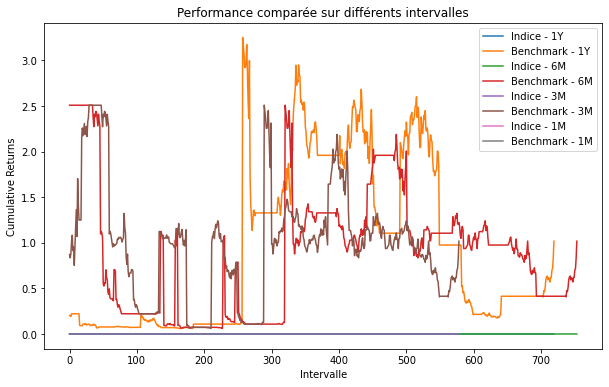

In [25]:
test.plot_performance_intervals(bench)

Implementing Momentum Crossover Strategy with Volatility Filters...


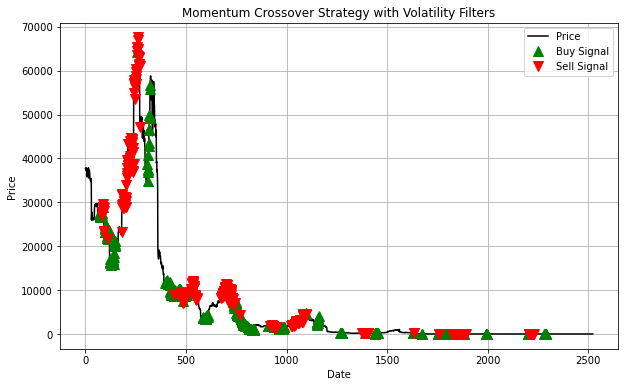

,Asset,Position
0,BTC,Hold
1,BTC,Hold
2,BTC,Hold
3,BTC,Hold
4,BTC,Hold
...,...,...
2518,XRP,Hold
2519,XRP,Hold
2520,XRP,Hold
2521,XRP,Hold


In [26]:
test.momentum_crossover_strategy()

In [27]:
test.volume_weighted_strategy()

New Positions: {'BTC': 0.18075111596427088, 'ETH': 6.002889134976286, 'XRP': 133357.06753791476}


{'BTC': 0.18075111596427088,
 'ETH': 6.002889134976286,
 'XRP': 133357.06753791476}